This notebook evaluates the probe on the set of test words

In [1]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos, save_embeds_with_wts
import numpy as np
import pandas as pd

<Figure size 432x288 with 0 Axes>

## Data Prep

Reading in experimental data to see which words to run the model on

In [2]:
db = access_db()


In [3]:
results = pd.read_csv('../data/approved_expt_results.csv')
incl_users = results['userID'].unique()

In [4]:
test_repeat_lem_cnt = get_lemma_counts(results, incl_users, db)
test_words = test_repeat_lem_cnt[test_repeat_lem_cnt['num_trials'] > 10]['lemma']

## Modeling

Compute F1 scores through cross validation

In [5]:
model_data = {}
test_stats = []
incorrect = []
for w in test_words:
    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                               use_masc = False, delim = '_')
    model_data[w] = model_results
    test_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_acc': np.mean(model_results['acc'])})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracies and F1 scores for Test Words for 5 fold Cross Validation 

In [6]:
model_perf = pd.DataFrame(test_stats).sort_values('avg_f1', ascending = False)

In [7]:
model_perf

,word,avg_f1,avg_acc
1,area_n,0.921003,0.921592
3,ask_v,0.905535,0.911743
16,raise_v,0.899040,0.904412
12,school_n,0.867553,0.888424
20,light_n,0.858904,0.854945
10,heart_n,0.811781,0.816667
25,man_n,0.790066,0.798510
18,glass_n,0.788926,0.817857
22,point_n,0.787440,0.796377
2,door_n,0.773686,0.792593


## Analysis of Classifier Performance

We plot F1 score with respect to entropy and number of senses

In [10]:
model_perf['Part of Speech'] = model_perf['word'].apply(lambda s: s.split("_")[1])
model_perf['Part of Speech'].replace({"n": "Noun", "v": "Verb"}, inplace = True)
model_perf

,word,avg_f1,avg_acc,Part of Speech
1,area_n,0.921003,0.921592,Noun
3,ask_v,0.905535,0.911743,Verb
16,raise_v,0.899040,0.904412,Verb
12,school_n,0.867553,0.888424,Noun
20,light_n,0.858904,0.854945,Noun
10,heart_n,0.811781,0.816667,Noun
25,man_n,0.790066,0.798510,Noun
18,glass_n,0.788926,0.817857,Noun
22,point_n,0.787440,0.796377,Noun
2,door_n,0.773686,0.792593,Noun


Reading in the entropy data

In [11]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types_revised.csv')
semcor_entropy['word'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
with_entropy = model_perf.merge(semcor_entropy, on = 'word')

In [12]:
from adjustText import adjust_text

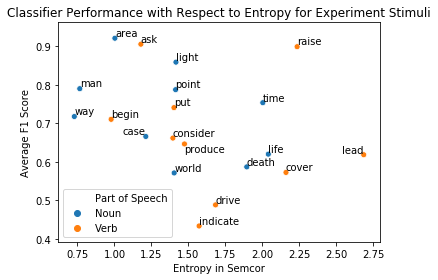

In [13]:
ent_f1 = sns.scatterplot(x = 'entropy', y = 'avg_f1', hue = 'Part of Speech', data = with_entropy)

texts = []
for x, y, s in zip(with_entropy['entropy'], with_entropy['avg_f1'], with_entropy['word'].apply(lambda s: s.split("_")[0])):
    texts.append(plt.text(x, y, s))

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1))
plt.xlabel("Entropy in Semcor")
plt.ylabel("Average F1 Score")
plt.title("Classifier Performance with Respect to Entropy for Experiment Stimuli")
plt.tight_layout()
plt.savefig("../../results/figures/f1_entropy_expt.png")

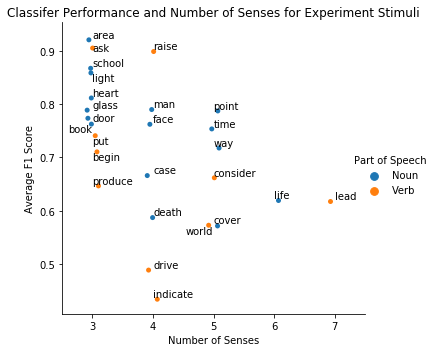

In [15]:
sns.catplot(x = 'num_senses', y = 'avg_f1', hue = 'Part of Speech', data = model_perf)
texts = []
for x, y, s in zip(model_perf['num_senses'] - 3, model_perf['avg_f1'], 
                   model_perf['word'].apply(lambda s: s.split("_")[0])): 
    texts.append(plt.text(x, y, s))

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1))

plt.title("Classifer Performance and Number of Senses for Experiment Stimuli")
plt.xlabel("Number of Senses")
plt.ylabel("Average F1 Score")
plt.tight_layout()
plt.savefig("../../results/figures/f1_num_sense_expt")

## Confusion Matrices

We plot the results from the experiment with the cosine similarity of the BERT centroids, as well as the confusion matrices for the classification task. 

In [12]:
import seaborn as sns

In [13]:
from matplotlib.backends.backend_pdf import PdfPages

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


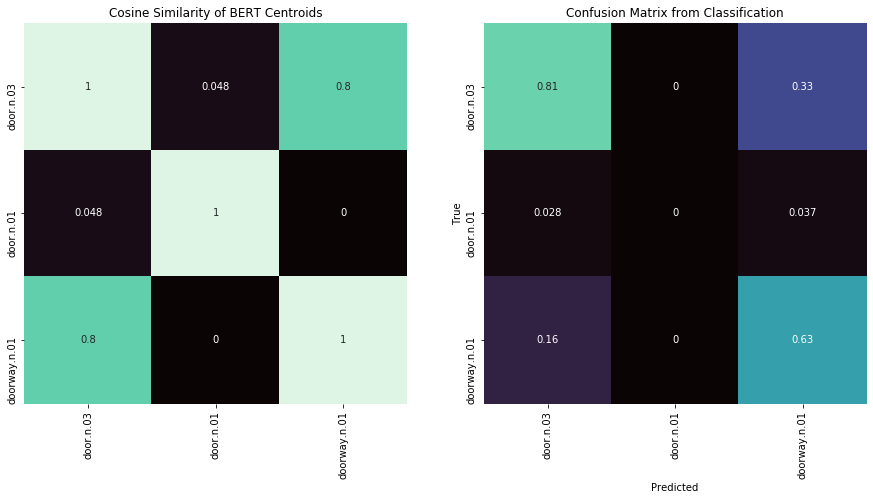

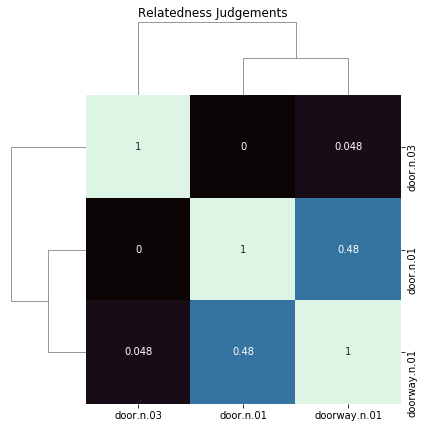

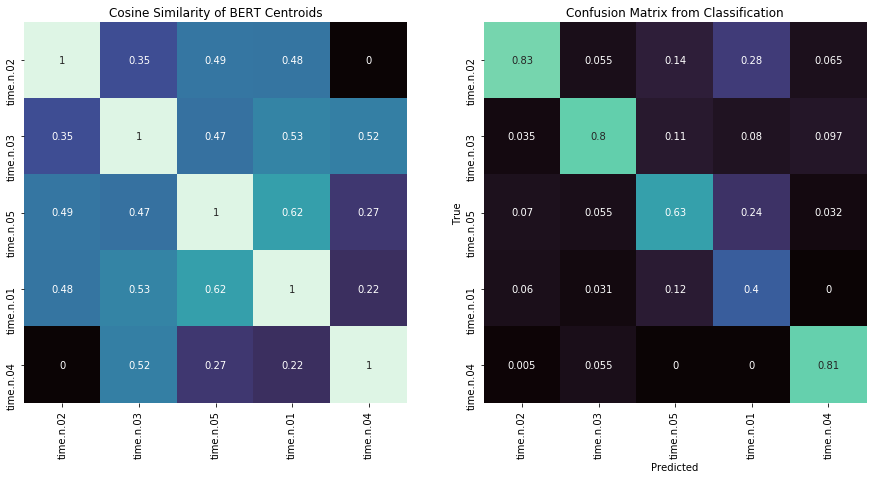

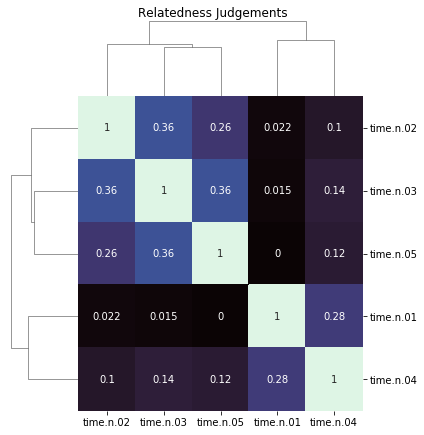

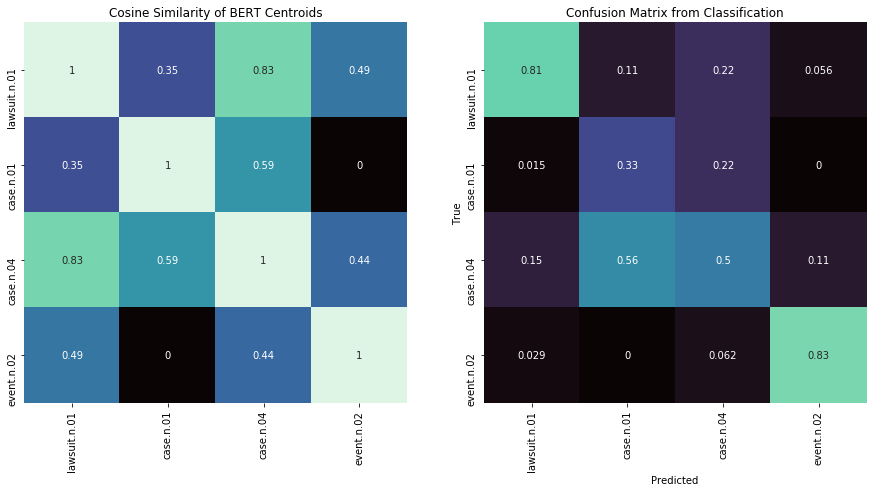

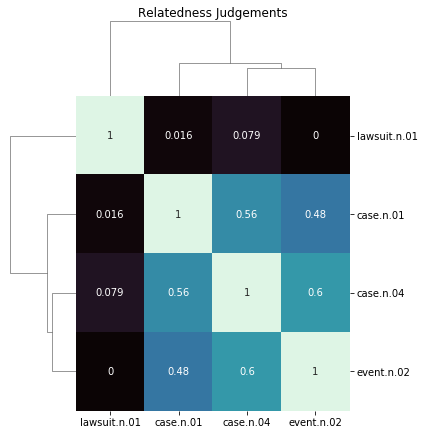

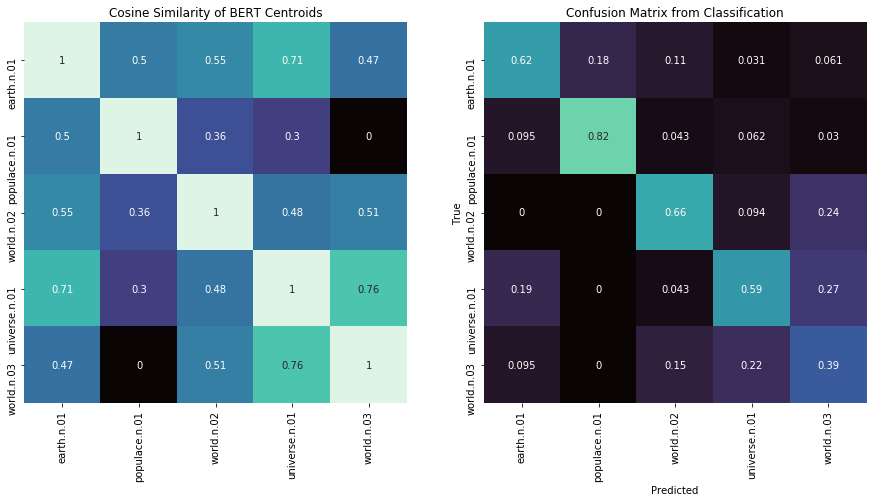

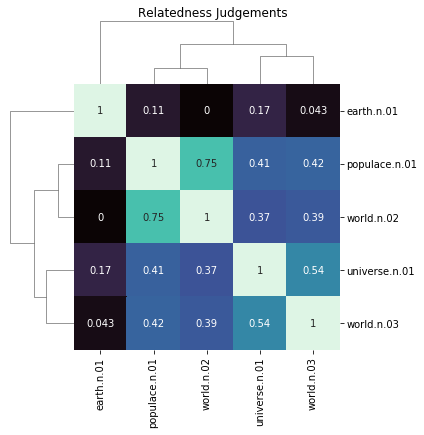

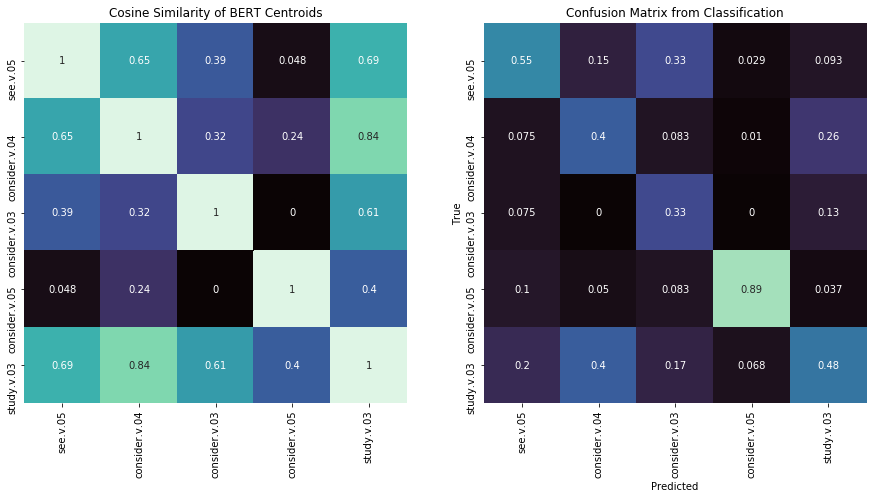

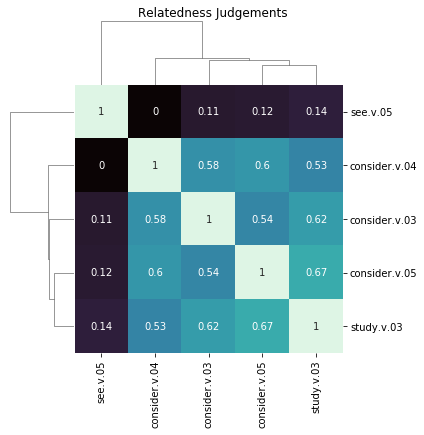

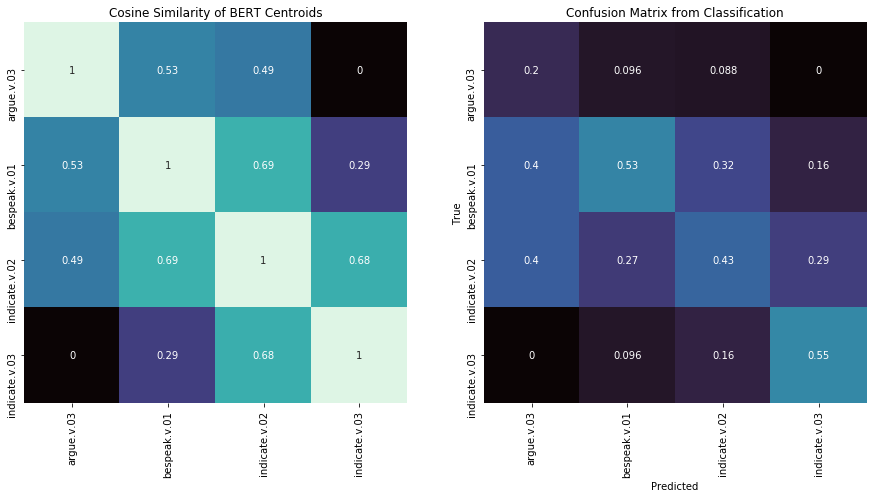

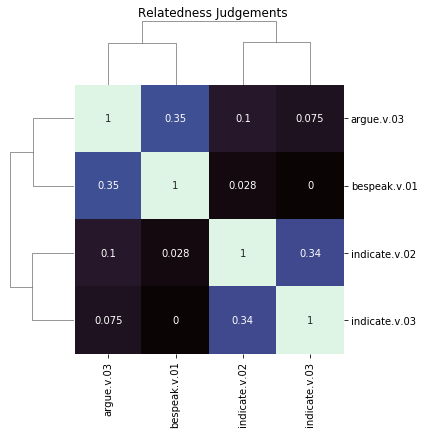

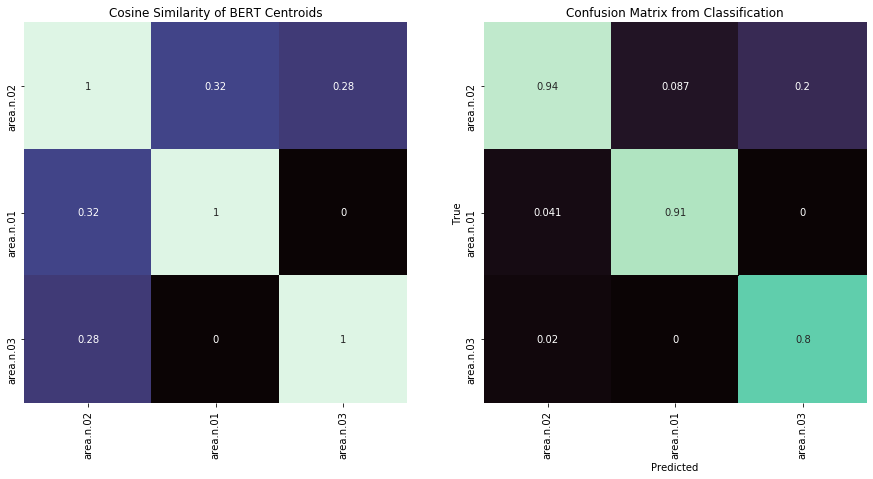

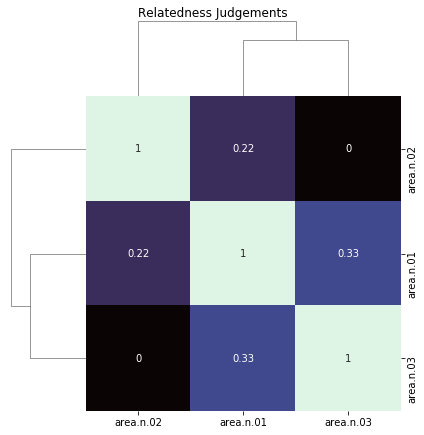

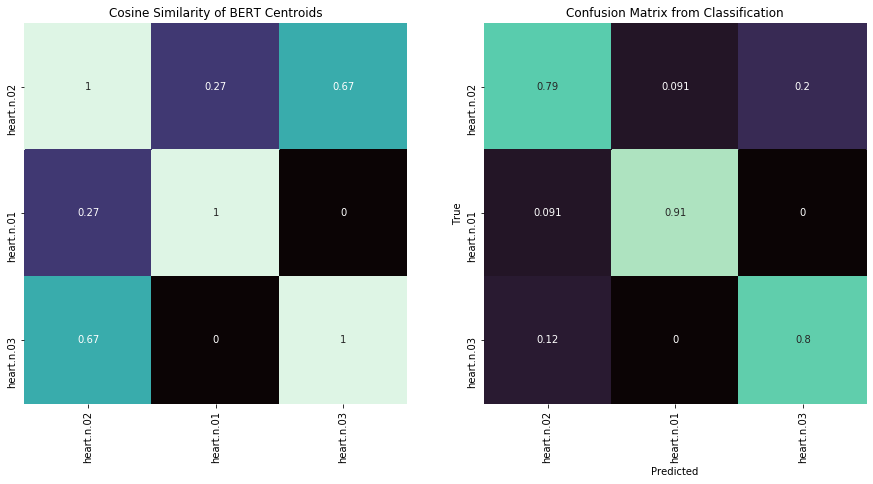

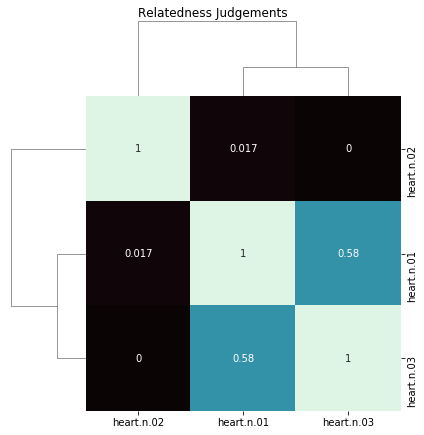

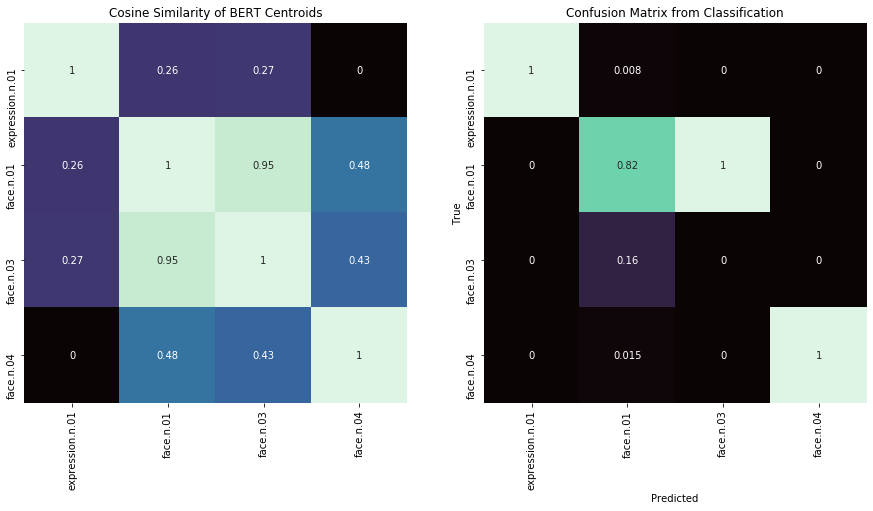

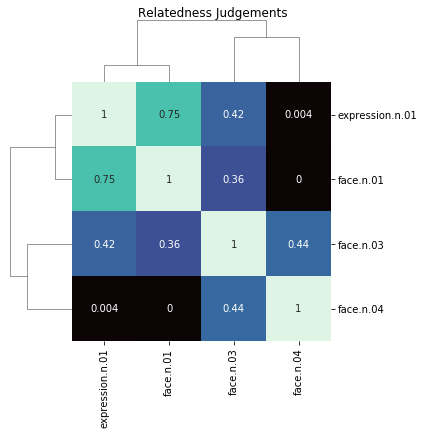

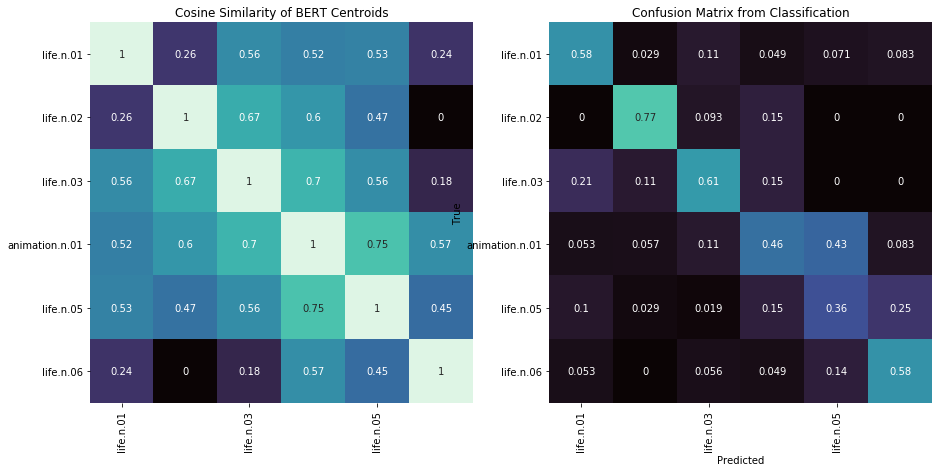

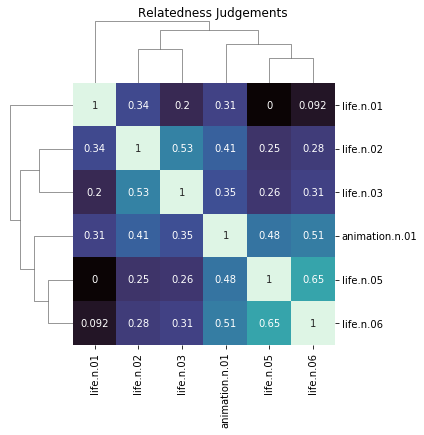

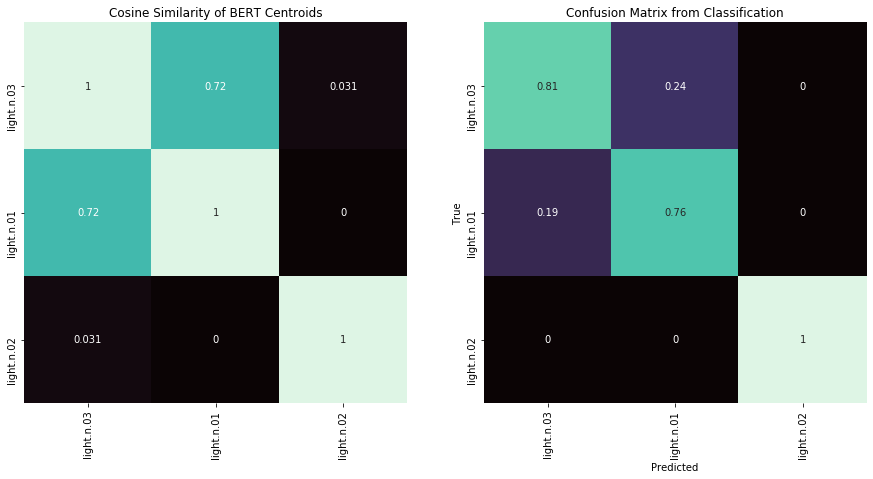

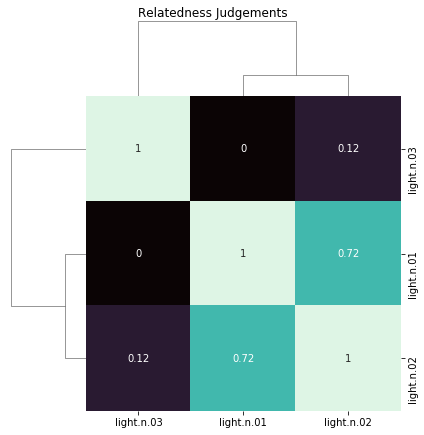

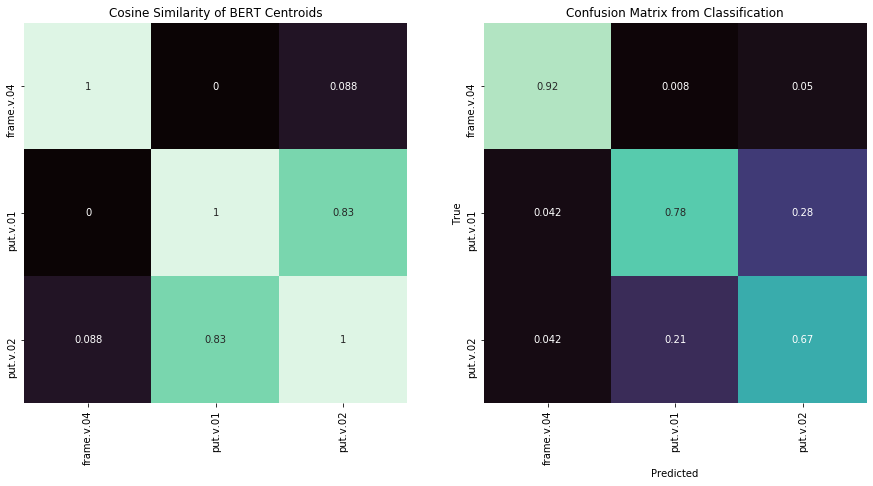

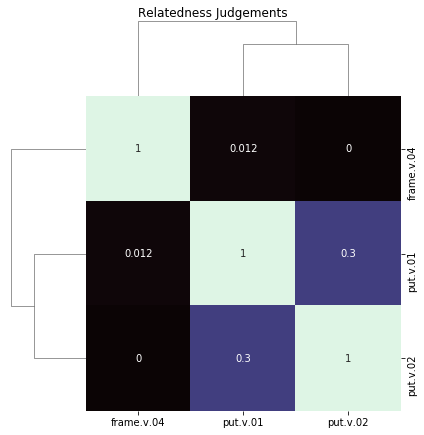

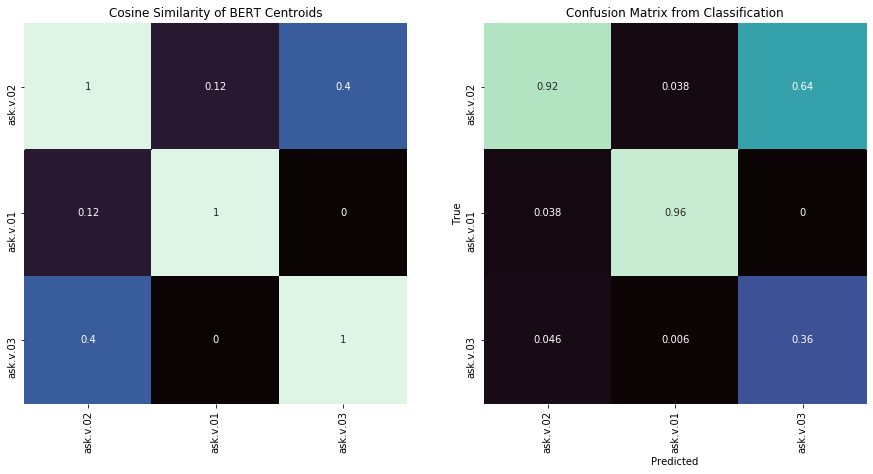

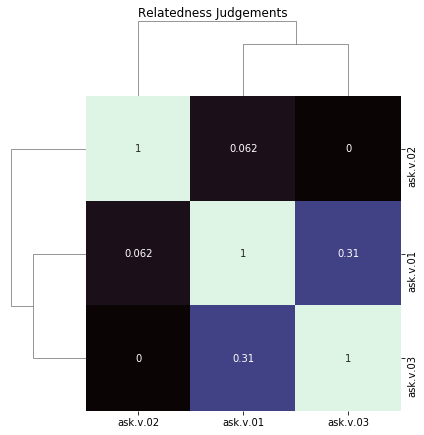

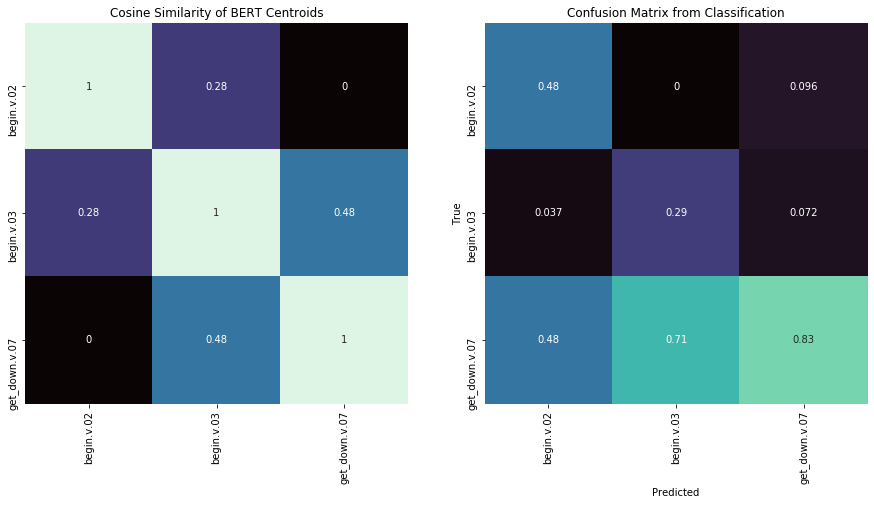

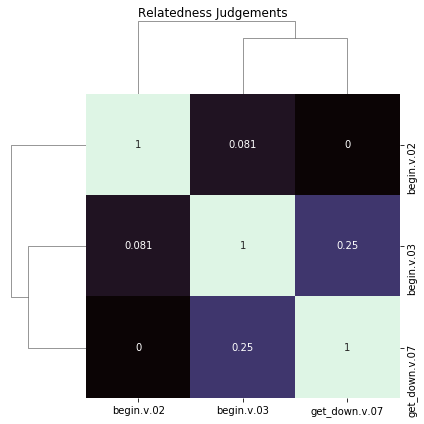

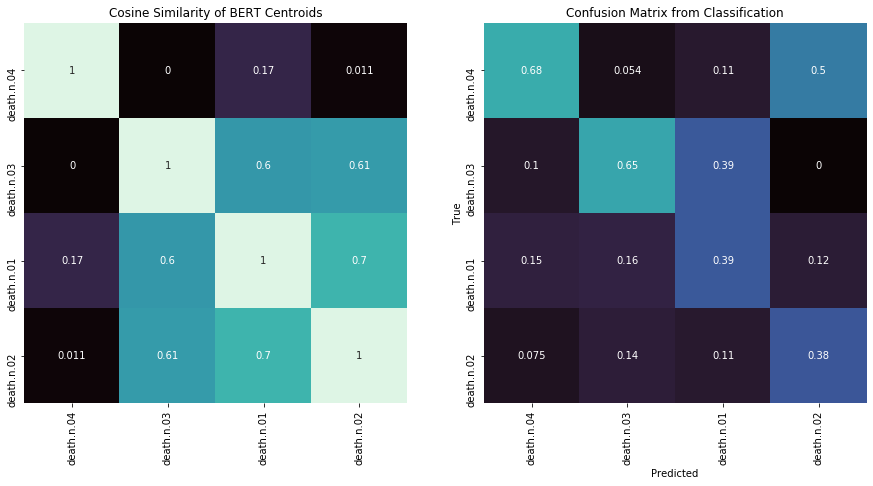

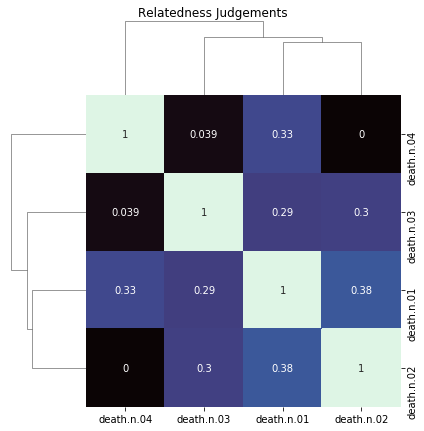

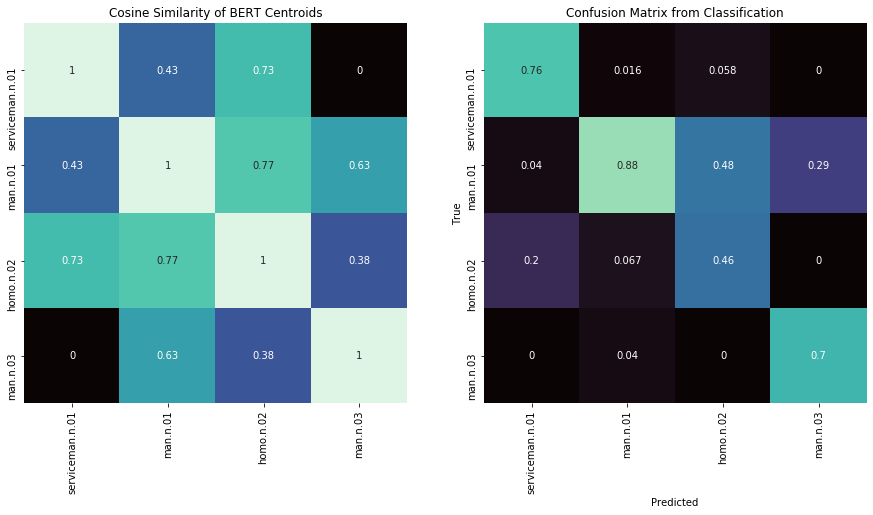

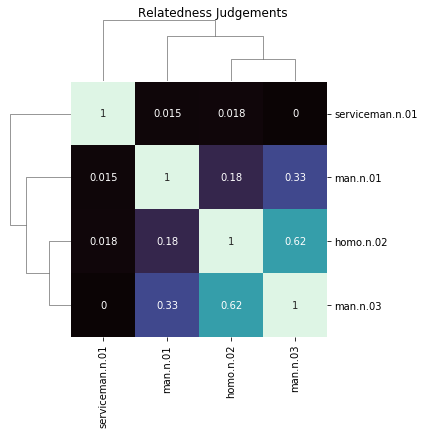

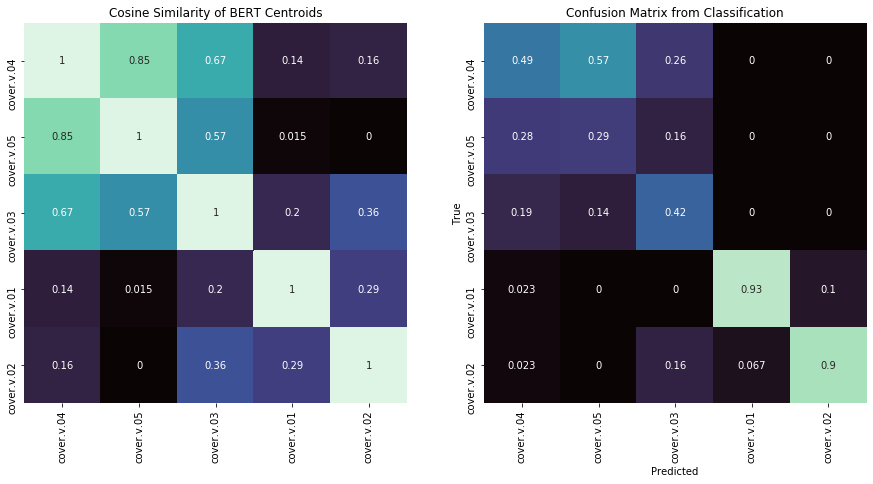

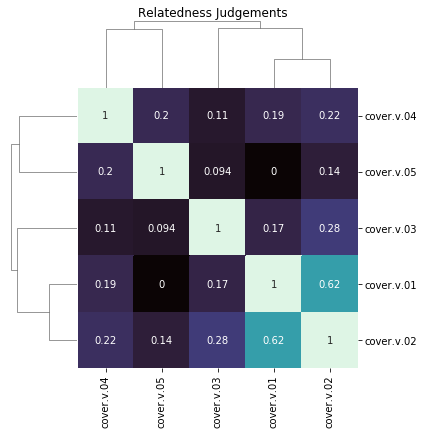

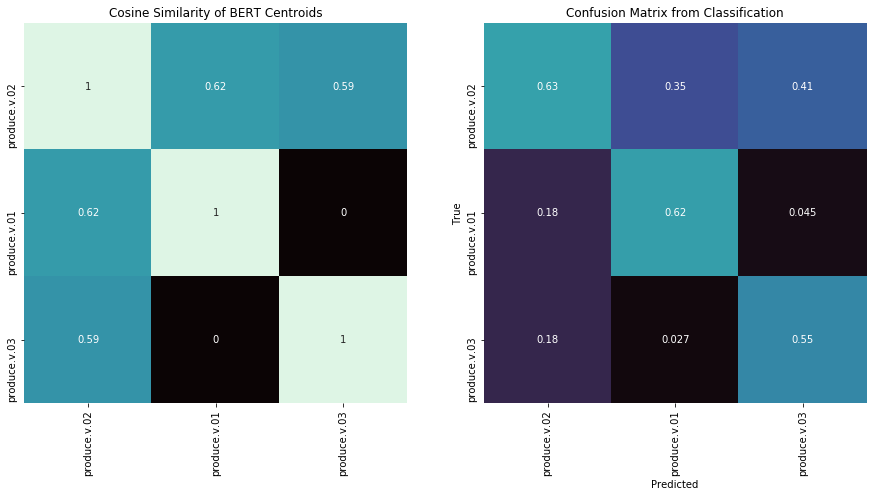

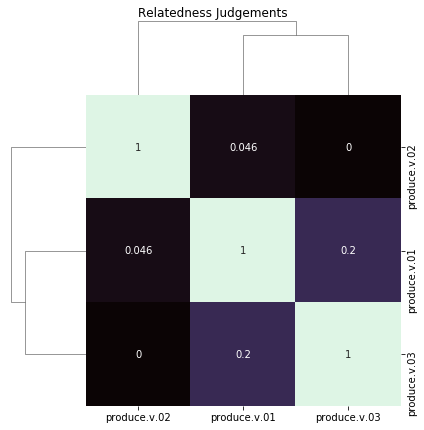

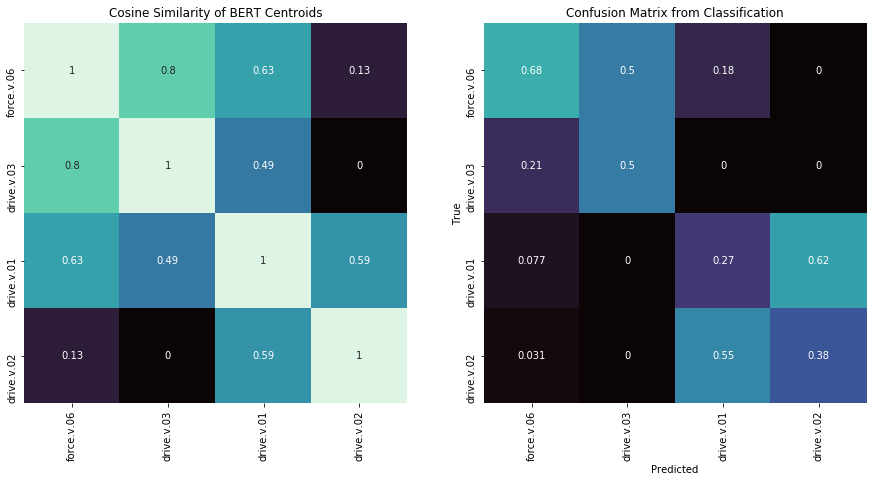

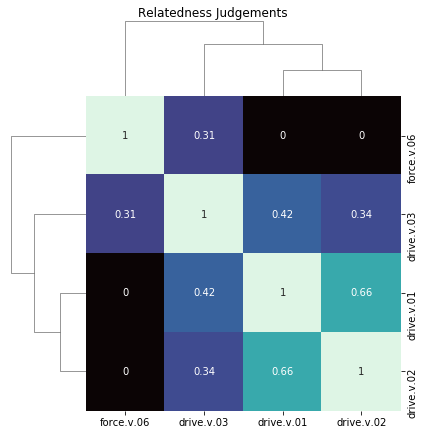

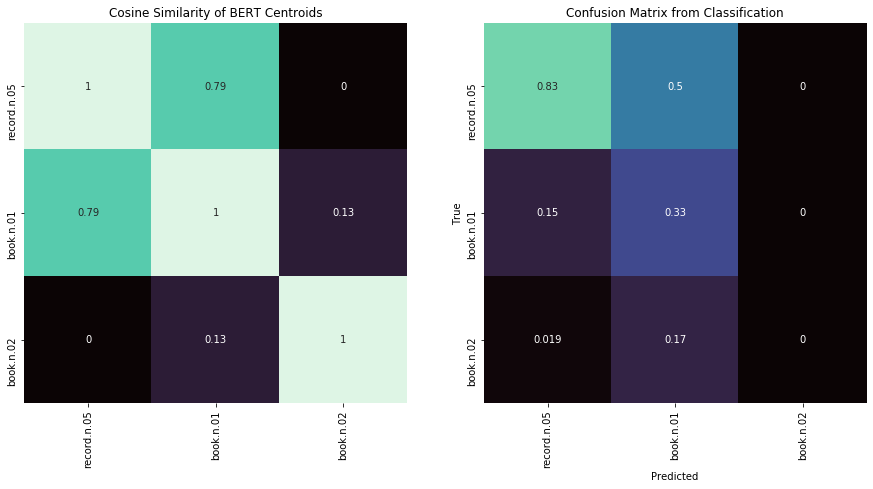

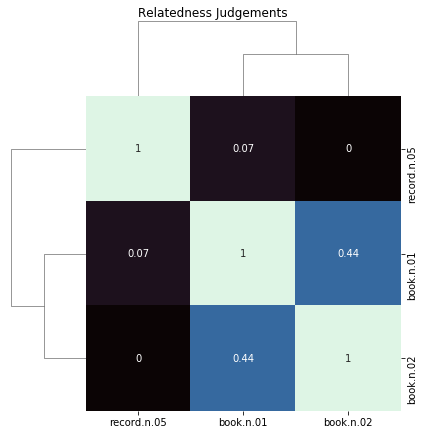

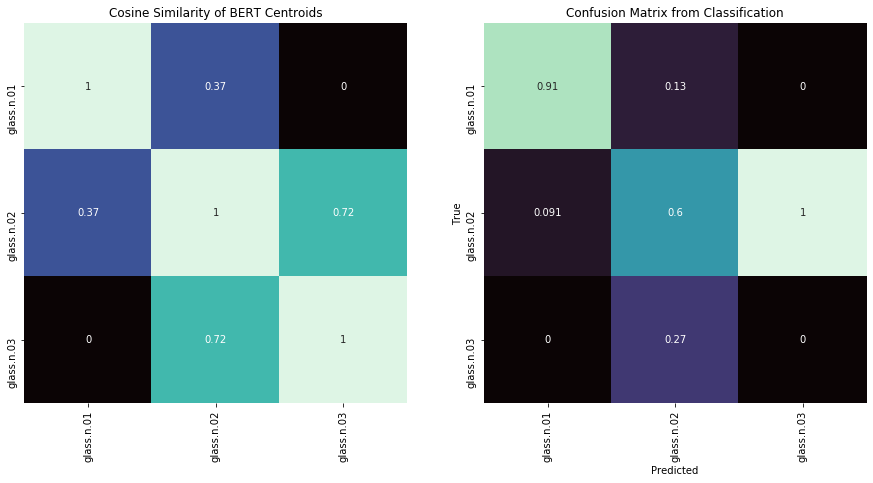

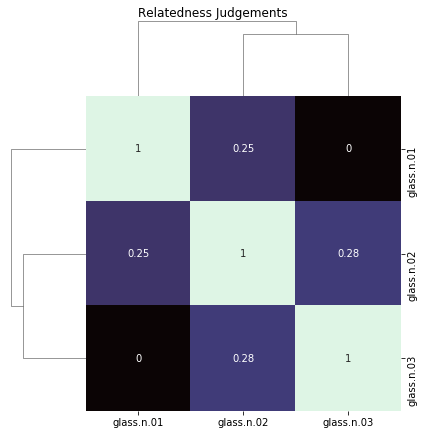

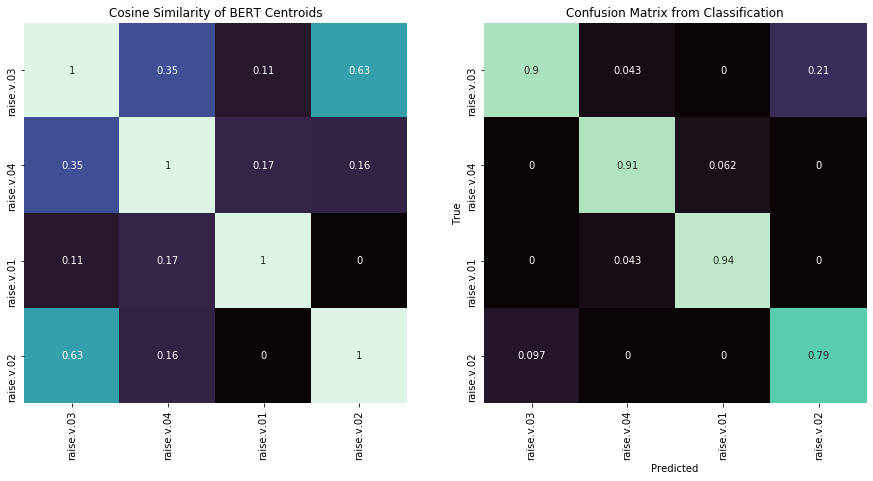

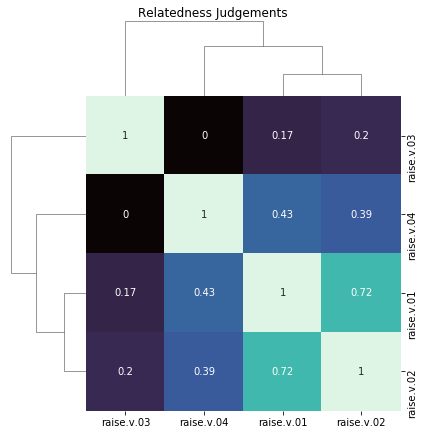

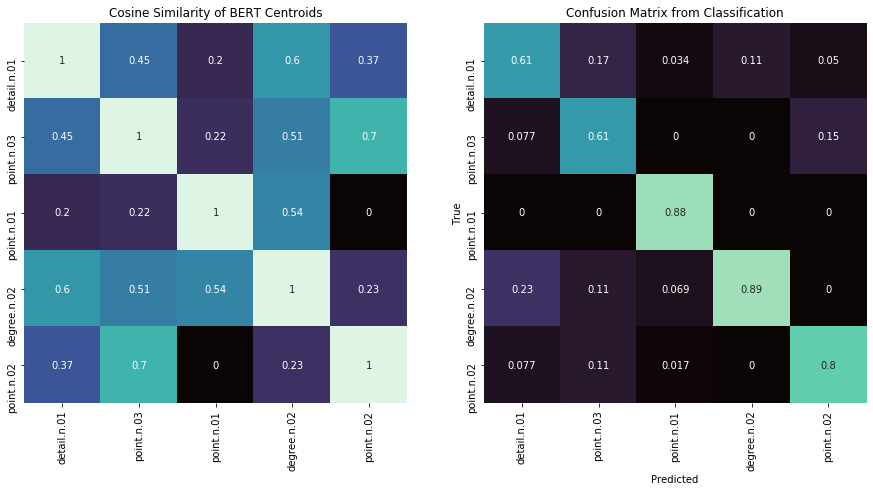

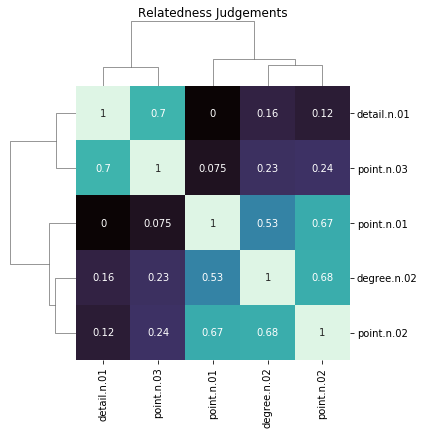

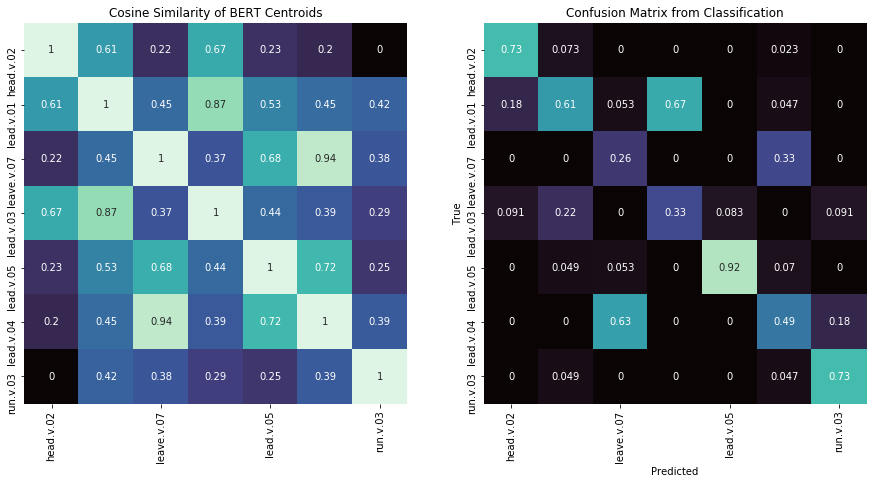

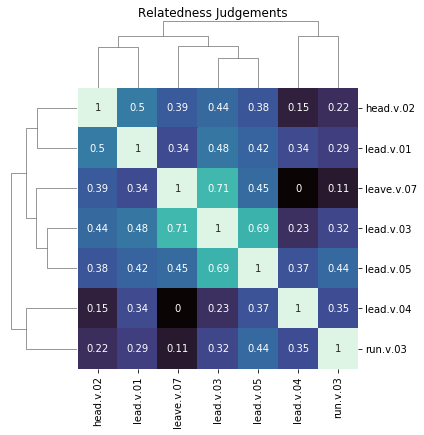

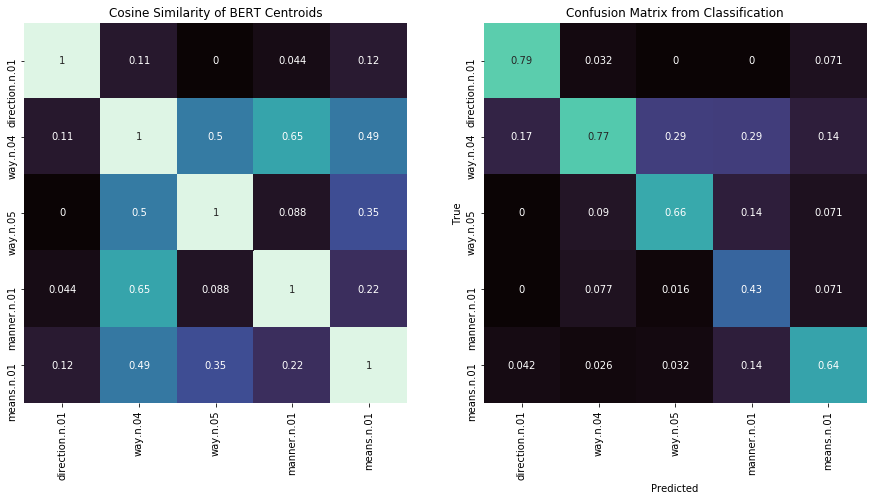

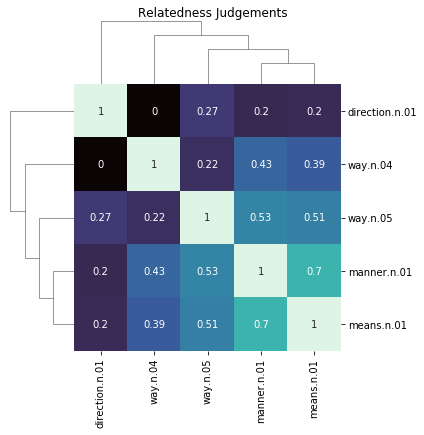

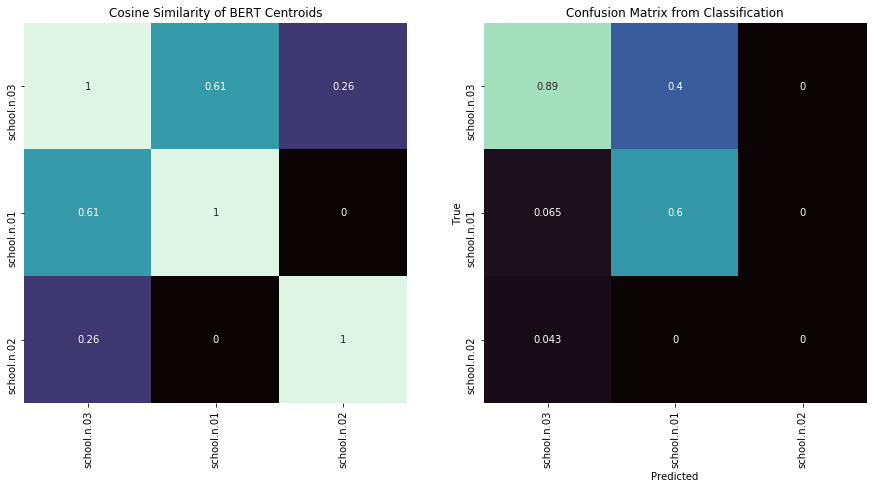

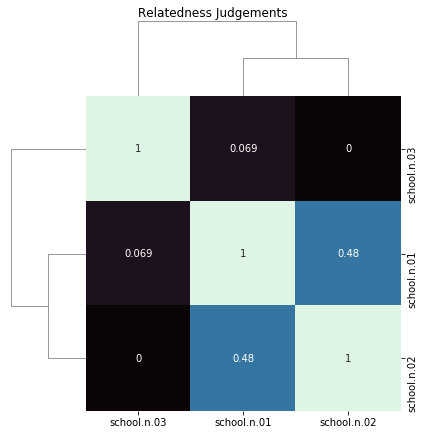

In [93]:
confusion_matrices = {w: {} for w in test_words}

for w in test_words:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2.4, 7))

    avg_reported = get_test_result_data(results, w, incl_users)
    senses = np.array([fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))])
    cg = sns.clustermap(mtx_to_df(1 - avg_reported, senses), cmap = 'mako', annot = True, figsize = (6, 6),
                           cbar_pos = None, vmin = 0, vmax = 1)
    cg.fig.suptitle('Relatedness Judgements', y = 1)

    reordered_sense_indices = cg.dendrogram_row.reordered_ind

    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = senses,
                                         corpus = 'semcor', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    bcs_fig = sns.heatmap(mtx_to_df(1 - bert_cs, senses, reorder = reordered_sense_indices),
                          ax = ax1, annot = True, cmap = 'mako', cbar = False,  vmin = 0, vmax = 1)
    bcs_fig.set_title("Cosine Similarity of BERT Centroids")

    word_matrices = model_data[w]['confusion_matrices']
    agg_confusion = np.sum(np.asarray(word_matrices), axis = 0)
    agg_confusion = np.nan_to_num(agg_confusion / np.sum(agg_confusion, axis = 0))
    confusion_matrices[w] = agg_confusion.tolist()
    conf_fig = sns.heatmap(mtx_to_df(agg_confusion, senses, reorder = reordered_sense_indices),
                           cmap = 'mako', ax = ax2, annot = True, cbar = False,  vmin = 0, vmax = 1)
    conf_fig.set_title("Confusion Matrix from Classification")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("True")
    fig.subplots_adjust(right = 5)
    

Writing the confusion matrices to disk

In [33]:
with open('../data/test_confusion_matrices.json', 'w') as f:
    f.write(json.dumps(confusion_matrices))

## Saving values with nonzero weights

In [19]:
from core.semcor_bert_pipeline import save_embeds_with_wts

In [20]:
for w in model_data.keys():
    results = model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w.replace('_', '.'))

door.n Proportion of Weights that are Nonzero 0.17578125
time.n Proportion of Weights that are Nonzero 0.6419270833333334
case.n Proportion of Weights that are Nonzero 0.16536458333333334
world.n Proportion of Weights that are Nonzero 0.1875
consider.v Proportion of Weights that are Nonzero 0.2981770833333333
indicate.v Proportion of Weights that are Nonzero 0.23046875
area.n Proportion of Weights that are Nonzero 0.24869791666666666
heart.n Proportion of Weights that are Nonzero 0.078125
face.n Proportion of Weights that are Nonzero 0.18489583333333334
life.n Proportion of Weights that are Nonzero 0.2734375
light.n Proportion of Weights that are Nonzero 0.08984375
put.v Proportion of Weights that are Nonzero 0.3255208333333333
ask.v Proportion of Weights that are Nonzero 0.53125
begin.v Proportion of Weights that are Nonzero 0.4674479166666667
death.n Proportion of Weights that are Nonzero 0.13411458333333334
man.n Proportion of Weights that are Nonzero 0.7369791666666666
cover.v Prop